# 1. Introduction

## Electrical properties of neurons

Neurons have two fundamental properties: 
1. Passively integrating voltage over time
2. Actively generating spikes when voltage crosses a threshold

The voltage integration is determined by the membrane properties of the neurons: Resistance and Capacitance. It can thus be accurately modelled with an RC circuit.

<img src="images/equivalent_neuron_circuit.png" width=500>

[//]: # 'Image source: https://neurotext.library.stonybrook.edu/C3/C3_3/C3_3.html'

a) Equivalent circuit of a cell - the RC circuit. Current (Im) is injected inside the cell and flows across the cell membrane to ground outside the cell. 

b) A square pulse of current (Im) injected into an RC circuit produces a slow exponentially saturating voltage response (Vm). Without a capacitor (dashed line) the voltage would instantly jump to the value dictated by Ohm's law $V = I R$ for the duration of the injected current step.

$$
C * dV/dt = (\frac{- V}{R} + I)
$$

## Synapses: AMPA & NMDA receptors

In addition to the neuron cell body, real synapses also have dynamics that depend on the cell's voltage. There are three main processes that cause this:

### 1. Time-dependent changes to the number of open synaptic channels 
 - because of neurotransmitter dynamics and channel kinetics

A | B
- | - 
<img src="images/synapse_diagram.jpg" width="300"> |<img src="images/alpha_epsp_timecourse.png" width="500"> 


### 2. Voltage-dependent changes to the number of open synaptic changes
E.g. Na<sup>+</sup> channels driving action potentials close as high voltages, thereby determining the peak amplitude of spikes (in Hodgkin-Huxley action potential dynamics)

<img src="images/na_channel_inactivation.png" width="400">

<!-- Things blocking the ion channels
E.g. 

E.g. at low voltages Mg<sup>2+</sup> ions block the flow through NMDA receptors

<img src="images/nmda_block.png" width="800"> -->


### 3. Voltage-dependent changes to the driving force (E)
 - As the neuron's voltage increases, lower driving force/electrical potential of ions causes a reduced current passing through individual synaptic channels

A | B
- | - 
<img src="images/ions.jpg" width="400"> | <img src="images/vm_circuit.jpg" width=500>





# 2. Modeling a neuron with fixed-conductance (non-volatile) synapses

<img src="images/Neuromorphic_circuit_diagram1.png" width="600"> 

In [1]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import torch
%load_ext autoreload
%autoreload 2 # the 2 means 'Reload all modules' every time before executing a cell

import utils as ut

ut.update_plot_defaults()

In [2]:
# Run simulation with fixed synaptic conductance and driving force 

# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

# Define simulation
def run_simulation(synapse_range, syn_tau):
    # Stimulus parameters
    first_stim_time = 50.  #ms
    delta_stim = 5. #ms    
    end_stim = 200
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
#     weights = np.random.uniform(0.2,5.,synapse_range)
    weights = np.ones(synapse_range)
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*E_cell], 
                          'V':[],'I':[], 'g':[]}
    
    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        V = np.ones(len(time)) * E_cell
        this_stim_time = stim_timesteps[synapse_id]
        g = weights[synapse_id]
        for t in range(this_stim_time, len(time)):            
            if t > end_stim/dt:
                g = 0
            E_syn = 70
            I = g * E_syn *1e-3 #currents converted from pA to nA
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt

                dgdt = -g/syn_tau
                g = g + dgdt*dt
        simulation_results['single_EPSPs'].append(V)

    # Simulate combined EPSPs
    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * E_cell
        single_EPSP = np.ones(len(time)) * E_cell
        I = np.zeros(len(time))
        g = np.zeros(len(time))
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]

        for t in range(len(time)): 
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0]
                g[t] += np.sum(weights[active_synapse_ids])      # nS
                
            if t > end_stim/dt:
                g[t] = 0
                
            E_syn = 70
            I[t] = g[t] * E_syn *1e-3 #currents converted from pA to nA
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                
                dgdt = -g[t] / syn_tau
                g[t+1] = g[t] + dgdt*dt

        simulation_results['V'].append(V)
        simulation_results['I'].append(I)
        simulation_results['g'].append(g)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    return simulation_results

synapse_range=4
simulation_results = run_simulation(synapse_range, syn_tau=10e10)

As we increase the number of active synapses, the total conductance and current increase, 
resulting in larger voltage depolarizations at the neuron soma.


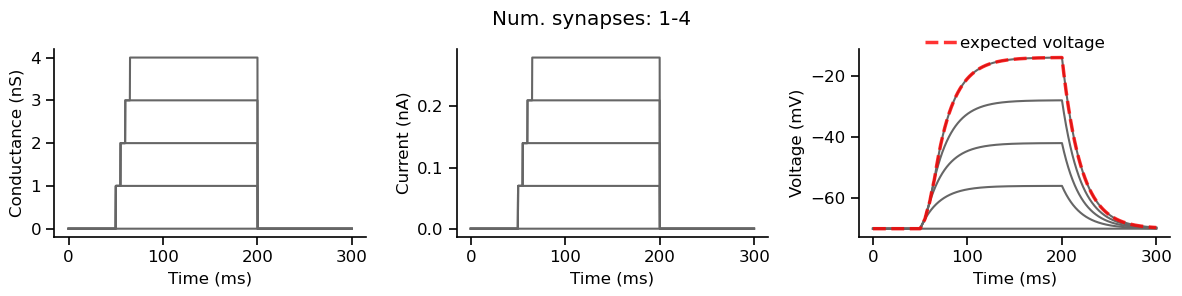

Without any time- or voltage-dependent components, the steady-state 
voltage scales linearly with the number of active synapses


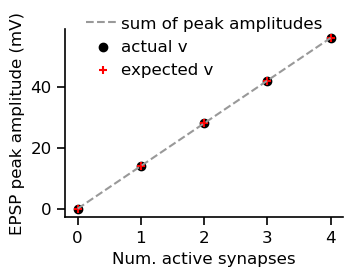

In [3]:
# Plot simulation results 

fig,ax = plt.subplots(1,3,figsize=(12,3))
line_color = [0.4,0.4,0.4]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'g': 'Conductance (nS)'}
ax[0].plot(time, simulation_results['g'], color=line_color)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(titles['g'])

ax[1].plot(time, simulation_results['I'], color=line_color)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(titles['I'])

ax[2].plot(time, simulation_results['V'], color=line_color)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[2].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

print('As we increase the number of active synapses, the total conductance and current increase, \nresulting in larger voltage depolarizations at the neuron soma.')
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')
plt.show()

singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)

expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

print('Without any time- or voltage-dependent components, the steady-state \nvoltage scales linearly with the number of active synapses')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)
plt.show()

# 3. Modeling a neuron with time-varying (volatile) synapses

<img src="images/Neuromorphic_circuit_diagram2.png" width="500">

In [4]:
# Run new simulation with variable conductance (short synaptic time-constant) 

synapse_range = 4
simulation_results = run_simulation(synapse_range, syn_tau=10)

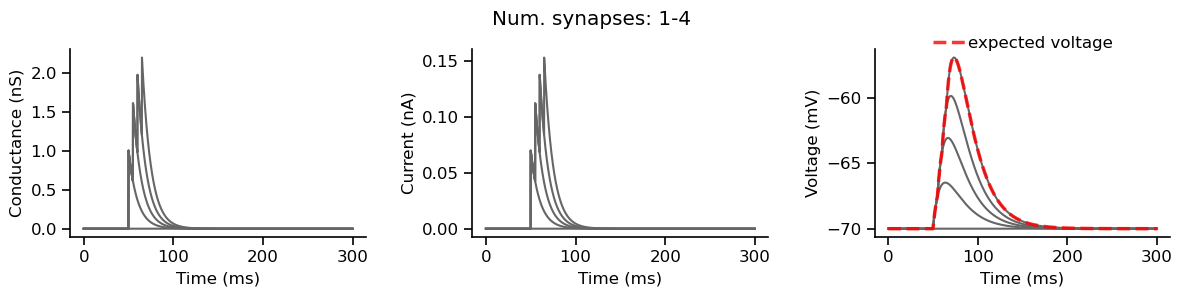

If synaptic conductances are time-varying (volatile), the voltage also decays, 
resulting in slightly sub-linear peak amplitude of the summed EPSP


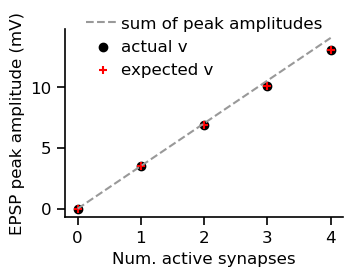

In [5]:
# Plot simulation results 

fig,ax = plt.subplots(1,3,figsize=(12,3))
line_color = [0.4,0.4,0.4]
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 'g': 'Conductance (nS)'}
ax[0].plot(time, simulation_results['g'], color=line_color)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(titles['g'])

ax[1].plot(time, simulation_results['I'], color=line_color)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(titles['I'])

ax[2].plot(time, simulation_results['V'], color=line_color)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[2].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[2].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')
plt.show()

singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)

expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

print('If synaptic conductances are time-varying (volatile), the voltage also decays, \nresulting in slightly sub-linear peak amplitude of the summed EPSP')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)
plt.show()

# <font color='blue'> 4. Emulating synaptic time-constants in neuromorphic hardware </font>

<img src="images/Neuromorphic_circuit_diagram3.png" width="550">

In [102]:
# Define material properties of VO2 volatile resistors 

class Volatile_Resistor():
    def __init__(self, dt):
        self.dt = dt
        self.g = 0
        self.g_history = []
        self.controlV = 0
        self.controlV_history = []
        
    def time_step(self, num_timesteps=1):
        for t in range(num_timesteps):
            self.g_history.append(self.g)
            self.controlV_history.append(self.controlV)

            g_eq = self.transfer_func(self.controlV) 
            dgdt = (g_eq - self.g) / self.tau(self.controlV)
            self.g += dgdt * self.dt
        
    def transfer_func(self, controlV):
        '''
        Function to convert between control_v and resistance
        '''
        slope = 1
        g = slope * controlV
        return g
    
    def inv_transfer_func(self, g):
        slope = 1
        controlV = g / slope
        return controlV
        
    def tau(self, controlV):
        tau = (1 + 0.4/(controlV + 1e-4)) * self.dt
        return tau
    
    def compute_controlV(self, tau):
        controlV = (0.4*dt / (tau-dt)) - 1e-4
        return controlV
    

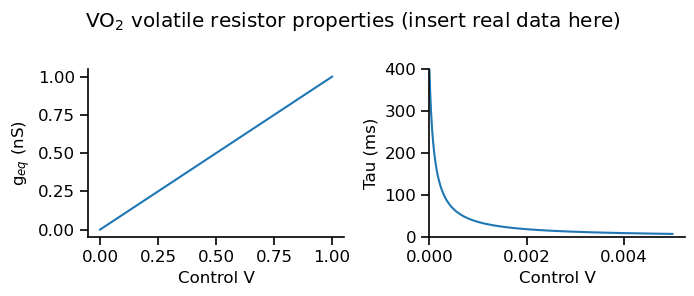

Pulse control V = 1.0
Baseline control V (to set the decay tau) = 0.001910050251256282
Tau = 20 ms


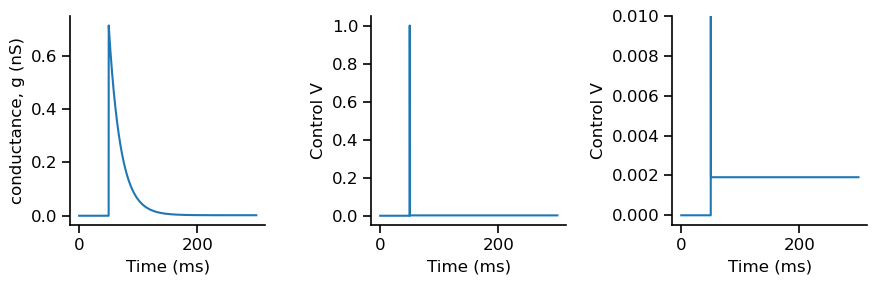

In [7]:
# Plot properties 
g_volatile = Volatile_Resistor(dt)

fig,ax = plt.subplots(1,2,figsize=[7,3])

control_v = np.linspace(0,1,100)
g_eq = g_volatile.transfer_func(control_v)
ax[0].plot(control_v,g_eq)
ax[0].set_xlabel('Control V')
ax[0].set_ylabel('g$_{eq}$ (nS)')

control_v = np.linspace(0,0.005,1000)
ax[1].plot(control_v,g_volatile.tau(control_v))
ax[1].set_xlabel('Control V')
ax[1].set_ylabel('Tau (ms)')
ax[1].set_ylim([0,400])
ax[1].set_xlim(left=0)

plt.suptitle('VO$_{2}$ volatile resistor properties (insert real data here)')
plt.tight_layout()
plt.show()

fig,ax = plt.subplots(1,3,figsize=[9,3])
baselineV = g_volatile.compute_controlV(20)
pulseV = 1.
print(f"Pulse control V = {pulseV}")
print(f"Baseline control V (to set the decay tau) = {baselineV}")
print(f"Tau = {round(g_volatile.tau(baselineV))} ms")

for t in time:
    if t==50:
        g_volatile.controlV = pulseV   
    if t>50:
        g_volatile.controlV = baselineV
    g_volatile.time_step()
    
ax[0].plot(time, g_volatile.g_history)
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('conductance, g (nS)')

ax[1].plot(time, g_volatile.controlV_history)
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel('Control V')

ax[2].plot(time, g_volatile.controlV_history)
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel('Control V')
ax[2].set_ylim([-0.0005,0.01])

plt.tight_layout()
plt.show()

In [219]:
# Run hardware-based simulation with variable conductance

def run_simulation(synapse_range, tau_ampa):
    first_stim_time = 50.  #ms
    delta_stim = 5. #ms
    end_time = 200. #ms
    stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*synapse_range, delta_stim) / dt
    stim_timesteps = np.round(stim_timesteps).astype(int) # to avoid floating point arithmetic errors
    controlV_dur = 0.4 //dt #ms

    # Neuron model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    V_cell = 0
    VO2_ampa = Volatile_Resistor(dt)
    baselineV = VO2_ampa.compute_controlV(tau_ampa)
#     weights = np.random.uniform(0.2,5.,synapse_range)
    weights = np.ones(synapse_range)
    
    simulation_results = {'single_EPSPs':[np.ones(len(time))*V_cell], 
                          'V':[],'I':[],'V_probe':[],'g_ampa':[],'controlV':[]}

    # Simulate single EPSPs
    for synapse_id in range(synapse_range):
        VO2_ampa = Volatile_Resistor(dt)
        V = np.ones(len(time)) * V_cell
        this_stim_time = stim_timesteps[synapse_id]
        stim_time_extended = np.arange(this_stim_time,this_stim_time+controlV_dur)
        
        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_time_extended:
                VO2_ampa.controlV = baselineV
            if t == this_stim_time:
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(weights[synapse_id])
                
            V_probe = 70
            I = VO2_ampa.g * V_probe *1e-3 #currents converted from pA to nA
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
            VO2_ampa.time_step()
        simulation_results['single_EPSPs'].append(V)

    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        VO2_ampa = Volatile_Resistor(dt)
        V = np.ones(len(time)) * V_cell
        I = np.zeros(len(time))
        V_probe = np.zeros(len(time)) 
        
        stim_timesteps_sub = stim_timesteps[0:num_synapses]        
        stim_timesteps_extended = np.repeat(stim_timesteps_sub,controlV_dur) + np.tile(np.arange(controlV_dur),len(stim_timesteps_sub))

        for t in range(len(time)): 
            if t > first_stim_time and t not in stim_timesteps_extended:
                VO2_ampa.controlV = baselineV
            if t in stim_timesteps_sub:
                active_synapse_ids = np.where(stim_timesteps_sub==t)[0]                
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(VO2_ampa.g + np.sum(weights[active_synapse_ids]))

            V_probe[t] = 70 
            I[t] = VO2_ampa.g * V_probe[t] *1e-3 #currents converted from pA to nA
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                
            VO2_ampa.time_step()

        simulation_results['V'].append(V)
        simulation_results['I'].append(I)
        simulation_results['V_probe'].append(V_probe)
        simulation_results['g_ampa'].append(VO2_ampa.g_history)
        simulation_results['controlV'].append(VO2_ampa.controlV_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    print(f"Pulse controlV = {pulseV}")
    print(f"Baseline controlV = {baselineV}")
    print(f"Tau = {round(g_volatile.tau(baselineV))} ms")
    return simulation_results

synapse_range = 4
simulation_results = run_simulation(synapse_range, tau_ampa=20)

Pulse controlV = 1.0
Baseline controlV = 0.001910050251256282
Tau = 20 ms


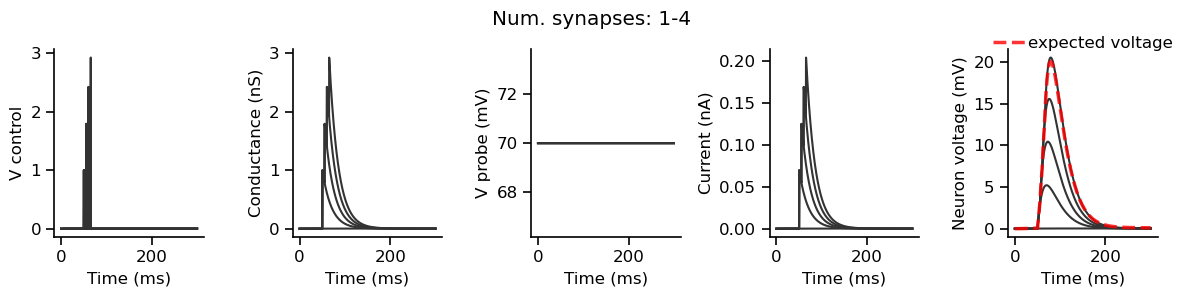

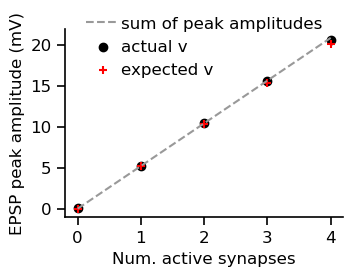

In [221]:
# Plot simulation results 

fig,ax = plt.subplots(1,5,figsize=(12,3))
titles = {'V': 'Neuron voltage (mV)', 'I': 'Current (nA)', 
          'g_ampa': 'Conductance (nS)', 'V_probe':'V probe (mV)', 'controlV':'V control'}

plot_nr = 0
ax[plot_nr].plot(time, simulation_results['controlV'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlV'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['g_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['g_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V_probe'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V_probe'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['I'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

baselines = simulation_results['single_EPSPs'][0,:]
summed_EPSP_trace = np.sum(simulation_results['single_EPSPs']-baselines,axis=1) + baselines[0]
ax[plot_nr].plot(time,summed_EPSP_trace,'--',linewidth=2.5,alpha=0.8,color='r', label='expected voltage')
ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')


singleEPSP_amplitudes = np.max(simulation_results['single_EPSPs'],axis=0) - baselines
linear_sum = np.cumsum(singleEPSP_amplitudes)
expected_amplitudes = np.max(np.cumsum(simulation_results['single_EPSPs']-baselines,axis=1),axis=0)
multiEPSP_amplitudes = np.max(simulation_results['V'],axis=0) - baselines
num_EPSPs = len(multiEPSP_amplitudes)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6], label='sum of peak amplitudes')
ax.scatter(np.arange(num_EPSPs), multiEPSP_amplitudes, color='k', label='actual v')
ax.scatter(np.arange(num_EPSPs), expected_amplitudes, marker='+',color='r',label='expected v')
ax.set_ylabel('EPSP peak amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)
plt.show()

# 5. Modeling a neuron with voltage-dependent driving force

<img src="images/Neuromorphic_circuit_diagram4.png" width="400">

In [222]:
def ampa_driving_force(V):
    E_rev = 0          # (mV) Reversal potential
    E_ampa = E_rev - V # (mV) Driving force
    return E_ampa   

def ampa_current(E_ampa, g_ampa=1):
    '''
    E_ampa: driving force (mV)
    g_ampa: conductance (nS)
    '''
    i_ampa = E_ampa * g_ampa # AMPA current in pA
    i_ampa *= 1e-3 # convert to nA
    return i_ampa

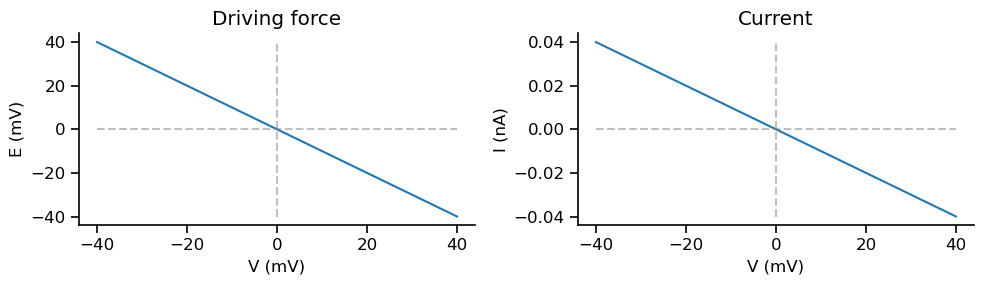

In [223]:
# Plot ampa properties 
fig,ax = plt.subplots(1,2, figsize=[10,3])
v = np.linspace(-40,40,1000)
E_ampa = ampa_driving_force(v)
ax[0].plot(v,E_ampa)
ax[0].plot([-40,40],[0,0],'--',color='gray',alpha=0.5)
ax[0].plot([0,0],[-40,40],'--',color='gray',alpha=0.5)
ax[0].set_xlabel('V (mV)')
ax[0].set_ylabel('E (mV)')
ax[0].set_title('Driving force')

i = ampa_current(E_ampa)
ax[1].plot(v,i, label='AMPA current')
ax[1].plot([-40,40],[0,0],'--',color='gray',alpha=0.5)
ax[1].plot([0,0],[-0.04,0.04],'--',color='gray',alpha=0.5)
ax[1].set_xlabel('V (mV)')
ax[1].set_ylabel('I (nA)')
ax[1].set_title('Current')

plt.tight_layout()
plt.show()

In [224]:
# Run simulation with time-varying conductance + voltage-dependent driving force 

def run_simulation(synapse_range, tau_ampa):
    stim_time = 50.  #ms
    delta_stim = 5. #ms
    end_time = 200. #ms

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
    
    simulation_results = {'V':[],'I':[],'E_ampa':[],'g_ampa':[],}

    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * E_cell
        I = np.zeros(len(time))
        E_ampa = np.zeros(len(time))
        g_ampa = np.zeros(len(time))
        
        stim_timesteps = np.arange(stim_time, stim_time+delta_stim*num_synapses, delta_stim) / dt
        stim_timesteps = np.round(stim_timesteps) # to avoid floating point arithmetic errors

        for t in range(len(time)): 
            if t in stim_timesteps[0:num_synapses]:
                g_ampa[t] += 5.      # nS
            if t > end_time/dt:
                g_ampa[t] = 0

            E_ampa[t] = ampa_driving_force(V[t])
            I[t] = g_ampa[t] * E_ampa[t] *1e-3 #currents converted from pA to nA
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt

                dgdt_ampa = -g_ampa[t]/tau_ampa
                g_ampa[t+1] = g_ampa[t] + dgdt_ampa*dt

        simulation_results['V'].append(V)
        simulation_results['I'].append(I)
        simulation_results['E_ampa'].append(E_ampa)
        simulation_results['g_ampa'].append(g_ampa)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    return simulation_results

synapse_range = 4
simulation_results = run_simulation(synapse_range, tau_ampa=20)

If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, 
resulting in strongly sub-linear summation of the individual potentials


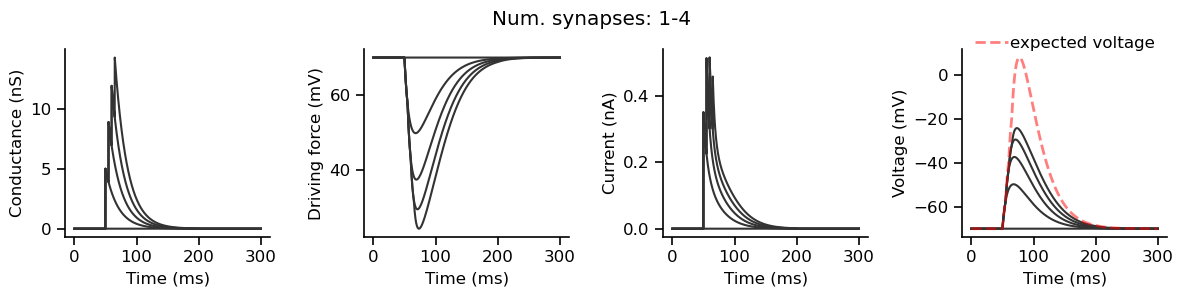

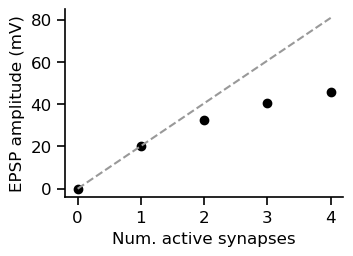

In [225]:
# Plot simulation results 
EPSP_amplitudes = np.max(simulation_results['V'],axis=0) - simulation_results['V'][0,:]

fig,ax = plt.subplots(1,4,figsize=(12,3))
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 
          'g_ampa': 'Conductance (nS)', 'E_ampa':'Driving force (mV)'}

ax[0].plot(time, simulation_results['g_ampa'], color=[0.2,0.2,0.2])
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(titles['g_ampa'])

ax[1].plot(time, simulation_results['E_ampa'], color=[0.2,0.2,0.2])
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(titles['E_ampa'])

ax[2].plot(time, simulation_results['I'], color=[0.2,0.2,0.2])
ax[2].set_xlabel('Time (ms)')
ax[2].set_ylabel(titles['I'])

ax[3].plot(time, simulation_results['V'], color=[0.2,0.2,0.2])
ax[3].set_xlabel('Time (ms)')
ax[3].set_ylabel(titles['V'])

single_EPSP_trace = simulation_results['V'][:,1]
baseline = single_EPSP_trace[0]
summed_EPSP_traces = np.zeros_like(single_EPSP_trace)
for stim in simulation_results['stim_times']:
    shift = int(stim - simulation_results['stim_times'][0])
    summed_EPSP_traces += np.roll(single_EPSP_trace,shift) - baseline
summed_EPSP_traces += baseline   
plt.plot(time,summed_EPSP_traces,'--',linewidth=2,color='r',alpha=0.5, label='expected voltage')
ax[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')

single_EPSP = EPSP_amplitudes[1]
num_EPSPs = len(EPSP_amplitudes)
linear_sum = np.arange(0, num_EPSPs*single_EPSP, single_EPSP)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6])
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes,color='k')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Num. active synapses')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

print('If synaptic driving force is voltage-dependent, the voltage steps get smaller with each successive synapse, \nresulting in strongly sub-linear summation of the individual potentials')

plt.show()

# <font color='blue'> 6. Emulating voltage-dependent driving force in neuromorphic hardware </font>

<img src="images/Neuromorphic_circuit_diagram5.png" width="400">

In [ ]:
# Define driving variable probe voltage 

def compute_probeV(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 0           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe
   
fig,ax = plt.subplots(figsize=[4,3])
V_cell = np.linspace(-40,40,100)
ax.plot(V_cell, compute_probeV(V_cell))
ax.set_xlabel('Cell Vm')
ax.set_ylabel("V probe")
ax.plot([0,0],[-40,40],'--',color=[.8,.8,.8])
ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
ax.set_title('Modulating the driving force to the volatile resistor',fontsize=12)
plt.show()

In [ ]:
# Run hardware simulation with voltage-dependent V_probe 

def run_simulation(synapse_range, tau_ampa):
    first_stim_time = 50.  #ms
    delta_stim = 5. #ms
    end_time = 200. #ms

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    V_cell = 0
    weights = np.random.uniform(3.,3.,synapse_range)

    simulation_results = {'V':[],'I':[],'V_probe':[],'g_ampa':[],'controlV':[]}

    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * V_cell
        I = np.zeros(len(time))
        V_probe = np.zeros(len(time))
        VO2_ampa = Volatile_Resistor(dt)
        baselineV = VO2_ampa.compute_controlV(tau_ampa)
        synapse_id = 0
        
        stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*num_synapses, delta_stim) / dt
        stim_timesteps = np.round(stim_timesteps) # to avoid floating point arithmetic errors
        
        for t in range(len(time)): 
            if t > first_stim_time:
                VO2_ampa.controlV = baselineV

            if t in stim_timesteps:
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(VO2_ampa.g + weights[synapse_id])
                synapse_id += 1

            V_probe[t] = compute_probeV(V[t])
            I[t] = VO2_ampa.g * V_probe[t] *1e-3 #currents converted from pA to nA
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                
            VO2_ampa.time_step()

        simulation_results['V'].append(V)
        simulation_results['I'].append(I)
        simulation_results['V_probe'].append(V_probe)
        simulation_results['g_ampa'].append(VO2_ampa.g_history)
        simulation_results['controlV'].append(VO2_ampa.controlV_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    print(f"Pulse controlV = {pulseV}")
    print(f"Baseline controlV = {baselineV}")
    print(f"Tau = {round(g_volatile.tau(baselineV))} ms")
    return simulation_results

synapse_range = 4
simulation_results = run_simulation(synapse_range, tau_ampa=20)

In [ ]:
# Plot simulation results 
EPSP_amplitudes = np.max(simulation_results['V'],axis=0) - simulation_results['V'][0,:]

fig,ax = plt.subplots(1,5,figsize=(12,3))
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 
          'g_ampa': 'Conductance (nS)', 'V_probe':'V$_{probe}$ (mV)', 'controlV':'V control'}

plot_nr = 0
ax[plot_nr].plot(time, simulation_results['controlV'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlV'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['g_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['g_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V_probe'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V_probe'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['I'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

single_EPSP_trace = simulation_results['V'][:,1]
baseline = single_EPSP_trace[0]
summed_EPSP_traces = np.zeros_like(single_EPSP_trace)
for stim in simulation_results['stim_times']:
    shift = int(stim - simulation_results['stim_times'][0])
    summed_EPSP_traces += np.roll(single_EPSP_trace,shift) - baseline
summed_EPSP_traces += baseline   
ax[plot_nr].plot(time,summed_EPSP_traces,'--',linewidth=2,color='r',alpha=0.5, label='expected voltage')
ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')

single_EPSP = EPSP_amplitudes[1]
num_EPSPs = len(EPSP_amplitudes)
linear_sum = np.arange(0, num_EPSPs*single_EPSP-0.1, single_EPSP)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6])
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes,color='k')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Num. active synapses')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()

In [ ]:
def V_probe(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 0           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe
   
V_cell = np.linspace(-40,40,100)

fig,ax = plt.subplots(figsize=[4,3])
V_cell = np.linspace(-40,40,100)
ax.plot(V_cell, V_probe(V_cell))
ax.set_xlabel('Cell Vm')
ax.set_ylabel("V probe")
ax.plot([0,0],[-40,40],'--',color=[.8,.8,.8])
ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
ax.set_title('Modulating the driving force through the volatile resistor',fontsize=12)
plt.show()

In [ ]:
# Simulation runtime parameters
dt = 0.1  # time step (ms)
T = 300   # simulation time (ms)
time = np.arange(0., T, dt)

def run_simulation(synapse_range, tau_ampa):
    first_stim_time = 50.  #ms
    delta_stim = 5. #ms
    end_time = 200. #ms

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    E_cell = -70
    weights = np.random.uniform(4.5,5,synapse_range)

    simulation_results = {'V':[],'I':[],'E_ampa':[],'g_ampa':[],'controlV':[]}

    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * E_cell
        I = np.zeros(len(time))
        E_ampa = np.zeros(len(time))
        VO2_ampa = Volatile_Resistor(dt)
        baselineV = VO2_ampa.compute_controlV(tau_ampa)
        synapse_id = 0
        
        stim_timesteps = np.arange(first_stim_time, first_stim_time+delta_stim*num_synapses, delta_stim) / dt
        stim_timesteps = np.round(stim_timesteps) # to avoid floating point arithmetic errors
        
        for t in range(len(time)): 
            if t > first_stim_time:
                VO2_ampa.controlV = baselineV

            if t in stim_timesteps:
                VO2_ampa.controlV = VO2_ampa.inv_transfer_func(VO2_ampa.g) + weights[synapse_id]
                synapse_id += 1

r            I[t] = VO2_ampa.g * E_ampa[t] *1e-3 #currents converted from pA to nA
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((E_cell-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt
                
            VO2_ampa.time_step()

        simulation_results['V'].append(V)
        simulation_results['I'].append(I)
        simulation_results['E_ampa'].append(E_ampa)
        simulation_results['g_ampa'].append(VO2_ampa.g_history)
        simulation_results['controlV'].append(VO2_ampa.controlV_history)
    simulation_results['stim_times'] = stim_timesteps

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    print(f"Pulse controlV = {pulseV}")
    print(f"Baseline controlV = {baselineV}")
    print(f"Tau = {round(g_volatile.tau(baselineV))} ms")
    return simulation_results

In [ ]:
synapse_range = 4

simulation_results = run_simulation(synapse_range, tau_ampa=20)

EPSP_amplitudes = np.max(simulation_results['V'],axis=0) - simulation_results['V'][0,:]

fig,ax = plt.subplots(1,5,figsize=(12,3))
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 
          'g_ampa': 'Conductance (nS)', 'E_ampa':'V probe (mV)', 'controlV':'V control'}

plot_nr = 0
ax[plot_nr].plot(time, simulation_results['controlV'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlV'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['g_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['g_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['E_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['E_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['I'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

single_EPSP_trace = simulation_results['V'][:,1]
baseline = single_EPSP_trace[0]
summed_EPSP_traces = np.zeros_like(single_EPSP_trace)
for stim in simulation_results['stim_times']:
    shift = int(stim - simulation_results['stim_times'][0])
    summed_EPSP_traces += np.roll(single_EPSP_trace,shift) - baseline
summed_EPSP_traces += baseline   
ax[plot_nr].plot(time,summed_EPSP_traces,'--',linewidth=2,color='r',alpha=0.5, label='expected voltage')
ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')

single_EPSP = EPSP_amplitudes[1]
num_EPSPs = len(EPSP_amplitudes)
linear_sum = np.arange(0, num_EPSPs*single_EPSP, single_EPSP)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6])
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes,color='k')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Num. active synapses')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()

In [ ]:
def V_probe(V_cell):
    '''Synapse driving force, computed as a function of the cell membrane potential (Vm)'''
    E_rev = 0           # (mV) Reversal potential
    V_probe = E_rev - V_cell # (mV) Driving force
    return V_probe
   
V_cell = np.linspace(-40,40,100)

fig,ax = plt.subplots(figsize=[4,3])
V_cell = np.linspace(-40,40,100)
ax.plot(V_cell, V_probe(V_cell))
ax.set_xlabel('Cell Vm')
ax.set_ylabel("V probe")
ax.plot([0,0],[-40,40],'--',color=[.8,.8,.8])
ax.plot([-40,40],[0,0],'--',color=[.8,.8,.8])
ax.set_title('Modulating the driving force through the volatile resistor',fontsize=12)
plt.show()

In [ ]:
synapse_range = 4

simulation_results = run_simulation(synapse_range, tau_ampa=20)

EPSP_amplitudes = np.max(simulation_results['V'],axis=0) - simulation_results['V'][0,:]

fig,ax = plt.subplots(1,5,figsize=(12,3))
titles = {'V': 'Voltage (mV)', 'I': 'Current (nA)', 
          'g_ampa': 'Conductance (nS)', 'E_ampa':'V probe (mV)', 'controlV':'V control'}

plot_nr = 0
ax[plot_nr].plot(time, simulation_results['controlV'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['controlV'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['g_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['g_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['E_ampa'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['E_ampa'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['I'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['I'])
plot_nr += 1

ax[plot_nr].plot(time, simulation_results['V'], color=[0.2,0.2,0.2])
ax[plot_nr].set_xlabel('Time (ms)')
ax[plot_nr].set_ylabel(titles['V'])

single_EPSP_trace = simulation_results['V'][:,1]
baseline = single_EPSP_trace[0]
summed_EPSP_traces = np.zeros_like(single_EPSP_trace)
for stim in simulation_results['stim_times']:
    shift = int(stim - simulation_results['stim_times'][0])
    summed_EPSP_traces += np.roll(single_EPSP_trace,shift) - baseline
summed_EPSP_traces += baseline   
ax[plot_nr].plot(time,summed_EPSP_traces,'--',linewidth=2,color='r',alpha=0.5, label='expected voltage')
ax[plot_nr].legend(loc='upper center', bbox_to_anchor=(0.5, 1.15))

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.suptitle(f'Num. synapses: 1-{synapse_range}')

single_EPSP = EPSP_amplitudes[1]
num_EPSPs = len(EPSP_amplitudes)
linear_sum = np.arange(0, num_EPSPs*single_EPSP, single_EPSP)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6])
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes,color='k')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Num. active synapses')

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()

# 7. Modeling voltage-dependent changes to channel opening: <br>  NMDA receptors


<img src="images/Neuromorphic_circuit_diagram4.png" width="400">

In [ ]:
def nmda_driving_force(V):
    E_rev = 0          # (mV) Reversal potential
    E_nmda = E_rev - V # (mV) Driving force
    return E_nmda

def nmda_sigmoid(V):
    '''
    V: postsynaptic voltage (mV)
    '''
    mg = 1.       # (mM) external magnesium concentration 
    vshift = -0   # (mV) shifts the mg unblock
    Kd = 9.98     # (mM) modulate Mg concentration-dependence
    gamma = 0.101 # (/mV) modulate slope of Mg sensitivity
    E_rev = 0.    # (mV) reversal potentital of NMDA channel  
    
    mgblock = 1 / (1 + np.exp(gamma * -(V-vshift)) * (mg / Kd)) # sigmoid voltage-dependent channel unblocking
    return mgblock

def nmda_current(E_nmda, mgblock=1, g_nmda=1):
    '''
    E_nmda: driving force (mV)
    g_nmda: conductance (nS)
    mgblock: unitless
    '''
    i_nmda = E_nmda * g_nmda * mgblock # NMDA current in pA
    i_nmda *= 1e-3 # convert to nA
    return i_nmda   


fig,ax = plt.subplots(figsize=[6,4])
v = np.linspace(-60,40,1000)
E_ampa = ampa_driving_force(v)
i = ampa_current(E_ampa)
ax.plot(v,-i, label='AMPA current')

v = np.linspace(-80,40,1000)
E_nmda = nmda_driving_force(v)
mgblock = nmda_sigmoid(v)
i = nmda_current(E_nmda,mgblock)
ax.plot(v,-i, label='NMDA current')

ax.plot([-80,40],[0,0],'--',color='gray',alpha=0.5)
ax.plot([0,0],[-0.06,0.04],'--',color='gray',alpha=0.5)
ax.set_xlabel('V (mV)')
ax.set_ylabel('I (nA)')
ax.legend()
plt.show()

# Simulation of single neuron with conductance-based synapses

In [ ]:
def run_simulation(synapse_range=5, nmda=False):
    
    # Simulation runtime parameters
    dt = 0.1  # time step (ms)
    T = 300   # simulation time (ms)
    time = np.arange(0., T, dt)
    stim_time = 50.  #ms
    delta_stim = 0.3 #ms

    # Model parameters
    R = 200 # cell input resistance (MOhm)
    C = 100 # cell capacitance (pF)
    cell_tau = R*C *1e-3 # time constant (ms)
    tau_ampa = 2 #ms
    tau_nmda = 100 #ms
    V_rest = -70
    
    simulation_results = {'V':[],'I_total':[], 'I_ampa':[], 'I_nmda':[], 
                          'E_ampa':[], 'E_nmda':[], 'g_ampa':[], 'g_nmda':[]}

    for num_synapses in range(synapse_range+1):
        # Initialize simulation variables
        V = np.ones(len(time)) * V_rest
        I = np.zeros(len(time))
        I_ampa = np.zeros(len(time))
        I_nmda = np.zeros(len(time))
        E_ampa = np.zeros(len(time))
        E_nmda = np.zeros(len(time))
        g_ampa = np.zeros(len(time))
        g_nmda = np.zeros(len(time))
        
        stim_timesteps = np.arange(stim_time, stim_time+delta_stim*num_synapses, delta_stim) / dt
        stim_timesteps = np.round(stim_timesteps) # to avoid floating point arithmetic errors

        for t in range(len(time)): 
            if t in stim_timesteps[0:num_synapses]:
                g_ampa[t] += 10.      # nS
                g_nmda[t] += 5. *nmda # nS

            E_ampa[t] = ampa_driving_force(V[t])
            I_ampa[t] = g_ampa[t] * E_ampa[t] *1e-3 #currents converted from pA to nA

            E_nmda[t] = nmda_driving_force(V[t]) 
            I_nmda[t] = g_nmda[t] * E_nmda[t] * nmda_sigmoid(V[t]) *1e-3 #currents converted from pA to nA
            
            I[t] = (I_ampa[t] + I_nmda[t]) 
            
            if t<len(time)-1: #don't update at the last timestep
                dVdt = ((V_rest-V[t]) + I[t]*R) * (1/cell_tau) 
                V[t+1] = V[t] + dVdt*dt

                dgdt_ampa = -g_ampa[t]/tau_ampa
                g_ampa[t+1] = g_ampa[t] + dgdt_ampa*dt

                dgdt_nmda = -g_nmda[t]/tau_nmda
                g_nmda[t+1] = g_nmda[t] + dgdt_nmda*dt
            
        simulation_results['V'].append(V)
        simulation_results['I_total'].append(I)
        simulation_results['I_ampa'].append(I_ampa)
        simulation_results['I_nmda'].append(I_nmda)
        simulation_results['E_ampa'].append(E_ampa)
        simulation_results['E_nmda'].append(E_nmda)
        simulation_results['g_ampa'].append(g_ampa)
        simulation_results['g_nmda'].append(g_nmda)

    for key,value in simulation_results.items():
        simulation_results[key] = np.array(value).T
        
    return simulation_results

In [ ]:
synapse_range = 10

EPSP_amplitudes = {}

fig,ax = plt.subplots(8,2,figsize=(12,18))

for col,simulation in enumerate(['No NMDA', 'NMDA']):
    if simulation=='NMDA':
        simulation_results = run_simulation(synapse_range, nmda=True)
    elif simulation=='No NMDA':
        simulation_results = run_simulation(synapse_range, nmda=False)
        
    measure_time = int(75 / 0.1)
    EPSP_amplitudes[simulation] = simulation_results['V'][measure_time,:] - simulation_results['V'][0,:]

    titles = {'V': 'Voltage (mV)', 'I_total': 'Total current (nA)', 
              'I_ampa': 'AMPA current (nA)',       'I_nmda': 'NMDA current (nA)', 
              'E_ampa': 'AMPA driving force (mV)', 'E_nmda': 'NMDA driving force (mV)',
              'g_ampa': 'AMPA conductance',        'g_nmda': 'NMDA conductance'}
    
    ylims = {'V': [-75,-0], 'I': [-0.2,2.5], 'i_ampa': [0,0.08], 'i_nmda': [-0.001,0.015], 
             'g_ampa': [0,60], 'g_nmda':[0,60]}
    
    ax[0,0].set_title('No NMDA', fontsize=16)
    ax[0,1].set_title('NMDA', fontsize=16, color='r')

    for i,key in enumerate(simulation_results):
        ax[i,col].plot(time, simulation_results[key], color=[0.2,0.2,0.2], label=simulation)
        ax[i,col].set_xlabel('Time (ms)')
        ax[i,col].set_ylabel(titles[key])
#         ax[i,col].set_ylim(ylims[key])      
#         ax[i,col].set_xlim([49,70])
        

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.suptitle(f'Num. synapses: 1-{synapse_range}',fontweight='bold',fontsize=16)
plt.show()

In [ ]:
single_EPSP = EPSP_amplitudes['No NMDA'][1]
num_EPSPs = len(EPSP_amplitudes['No NMDA'])
linear_sum = np.arange(0, num_EPSPs*single_EPSP, single_EPSP)

fig,ax = plt.subplots(figsize=[5,4])
ax.plot(np.arange(num_EPSPs), linear_sum, '--', c=[0.6,0.6,0.6])
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes['No NMDA'],color='k', label='AMPA (No NMDA)')
ax.scatter(np.arange(num_EPSPs), EPSP_amplitudes['NMDA'],color='r',label='AMPA + NMDA')
ax.set_ylabel('EPSP amplitude (mV)')
ax.set_xlabel('Num. active synapses')
ax.set_ylim(top=80)
ax.legend()

plt.tight_layout(pad=5)
plt.subplots_adjust(top=0.8)

plt.show()